<a href="https://colab.research.google.com/github/VomV/DS_Practice/blob/master/homl_2_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### HOML Ch2 E2E ML...


In [ ]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#spath for saving the figures
ROOT_DIR = '.'
CHAPTER_ID = 'E2E_ML'
IMAGES_PATH = os.path.join(ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
  print("saving figure:: ", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
#get the data

import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, 'housing.tgz')
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()


In [ ]:
fetch_housing_data()

In [ ]:
#Load data
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  return pd.read_csv(housing_path+'/housing.csv')

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


saving figure::  feature_hist


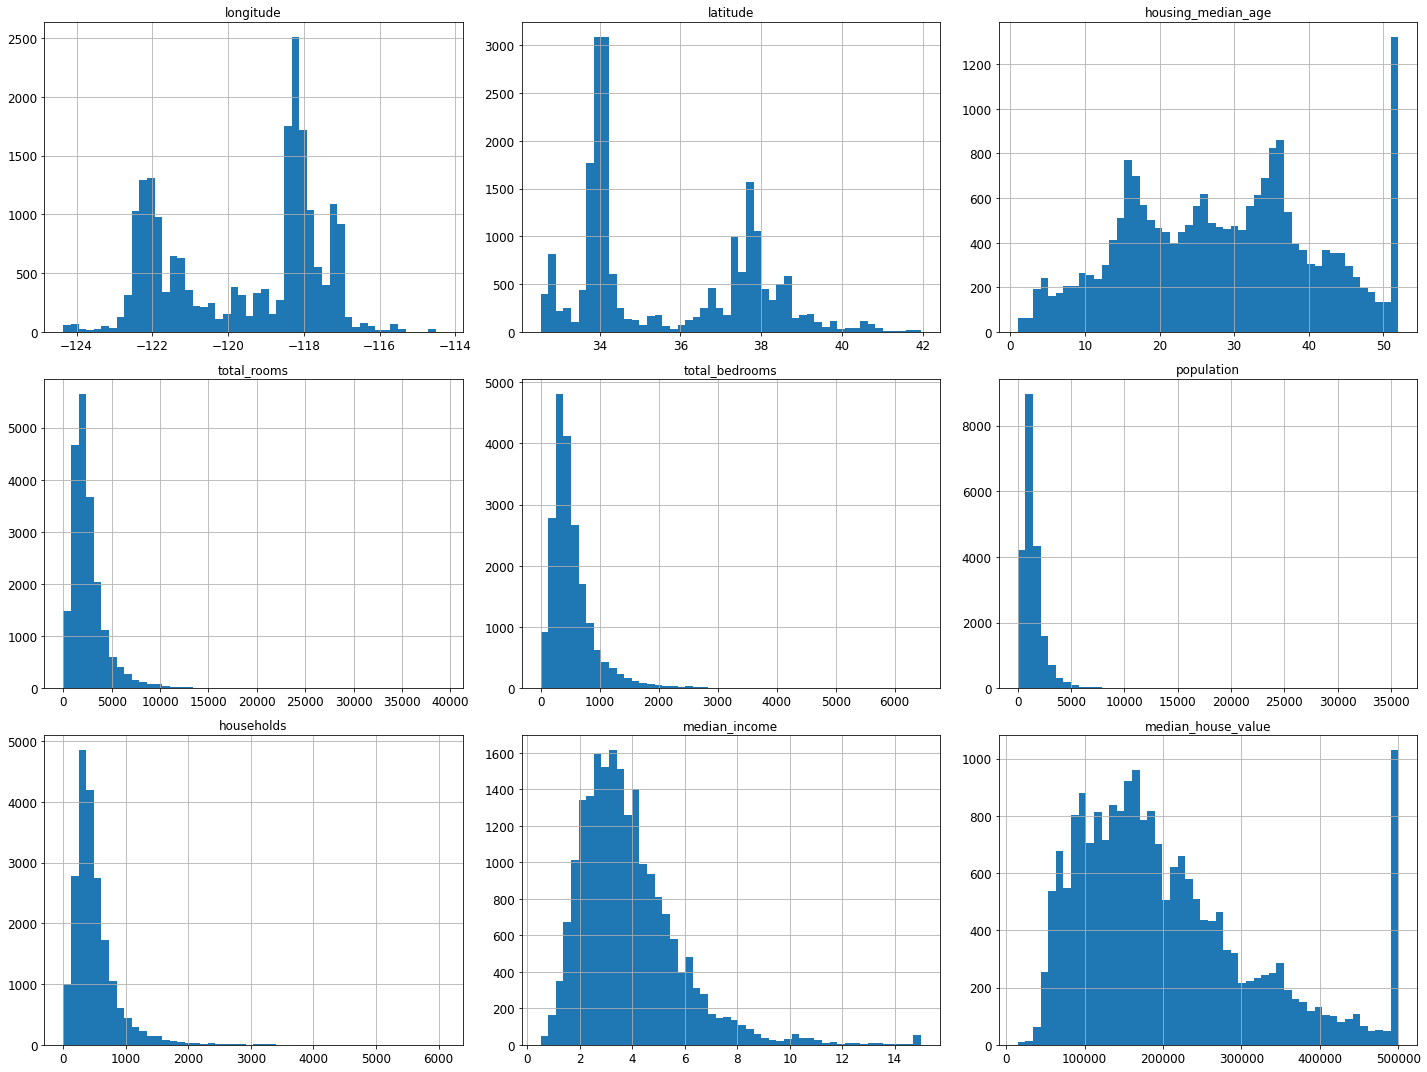

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("feature_hist")
plt.show()


In [ ]:
#set seed
np.random.seed(42)

In [ ]:
#Train test split func

import numpy as np

def train_test_split(data, test_ratio):

  #shuffle the data
  shuffled_id = np.random.permutation(len(data))
  test_size = int(len(data)* test_ratio)
  test_id = shuffled_id[:test_size]
  train_id = shuffled_id[test_size:]
  test = data.iloc[test_id]
  train = data.iloc[train_id]
  return train, test


In [ ]:
train, test = train_test_split(housing, 0.2)
len(test)

4128

##Train test split by ID to avoid data leakage

In [ ]:
from zlib import crc32

def test_set_check(id, test_ratio):
  return crc32(np.int64(id)) & 0xffffffff < test_ratio * 2**32

def train_test_split_by_id(data, test_ratio, id_col):
  ids = data[id_col]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
housing_id = housing.reset_index()
train, test = train_test_split_by_id(housing_id, 0.2, "index")

In [ ]:
test.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


In [ ]:
#Set id based on lat and long
housing_id['id'] = housing.latitude + 1000*housing.longitude
train, test = train_test_split_by_id(housing_id, 0.2, "id")
test.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(housing, test_size=0.2, random_state=42)
test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


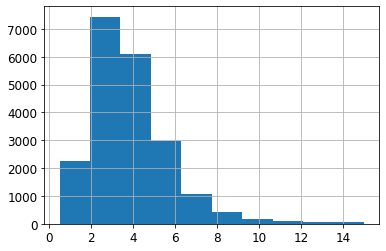

In [ ]:
housing['median_income'].hist()

In [ ]:
#Creating stratified split with median income

housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0, 1.5, 3, 4.5, 6, np.inf],
                               labels = [1, 2, 3, 4, 5])

housing['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

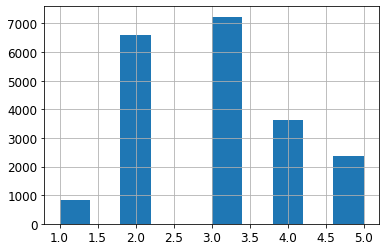

In [ ]:
housing['income_cat'].hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_stf_id, test_stf_id in split.split (housing, housing['income_cat']):
  train_stf = housing.iloc[train_stf_id]
  test_stf = housing.iloc[test_stf_id]

test_stf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,5
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN,4
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN,3
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND,3
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND,3


In [ ]:
test_stf['income_cat'].value_counts()/len(test_stf)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [ ]:
housing['income_cat'].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [ ]:
#Drop income cat

train_stf.drop('income_cat', axis=1, inplace=True)
test_stf.drop('income_cat', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#EDA

In [ ]:
house = train_stf.copy()

saving figure::  bad_map_plot


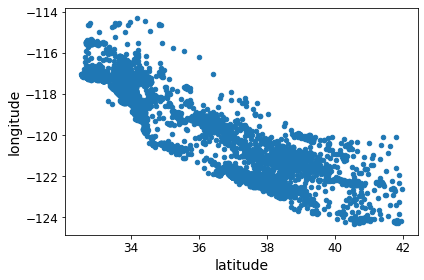

In [ ]:
house.plot(kind='scatter', x='latitude', y='longitude')
save_fig('bad_map_plot')

saving figure::  better_map_plot


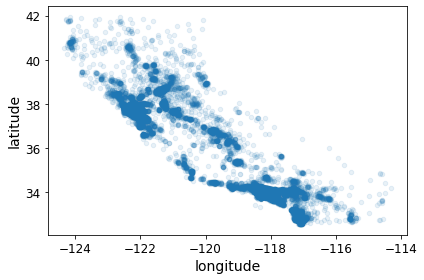

In [ ]:
house.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
save_fig('better_map_plot')

saving figure::  housing_prices_scatterplot


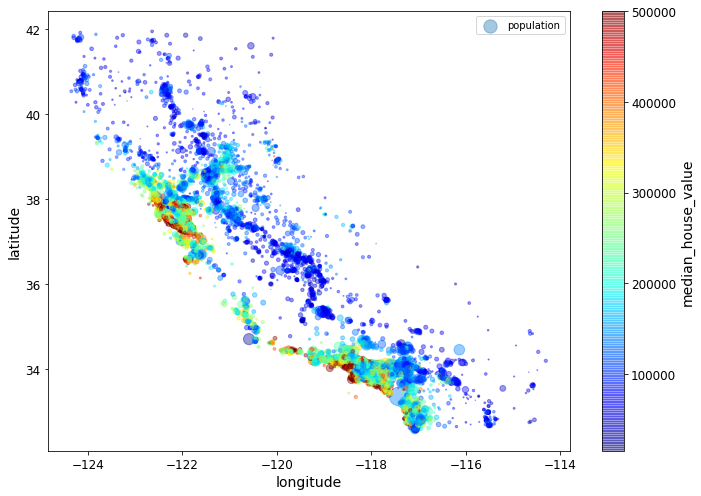

In [ ]:
house.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
           s=house['population']/100,
           label='population',
           figsize=(10,7),
           c='median_house_value',
           cmap=plt.get_cmap('jet'),
           colorbar=True,
           sharex=False
           )

plt.legend()
save_fig('housing_prices_scatterplot')

In [ ]:
#Download the California image

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
filename = 'california.png'

url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(IMAGES_PATH, filename))

('./images/E2E_ML/california.png', <http.client.HTTPMessage at 0x7f8ff98195d0>)

saving figure::  cali_housing_price_map_plot


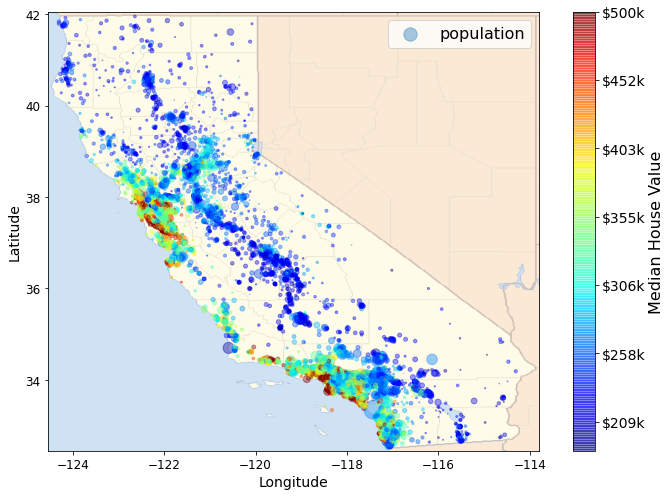

In [ ]:
import matplotlib.image as mpimg
cali_img = mpimg.imread(os.path.join(IMAGES_PATH, filename))

ax = house.plot(kind='scatter', x='longitude', y='latitude', figsize=(10,7),
                s=house['population']/100,
                label='population',
                c='median_house_value',
                cmap=plt.get_cmap('jet'),
                colorbar=False, alpha=0.4)

plt.imshow(cali_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))

plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Longitude', fontsize=14)

prices = housing['median_house_value']
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks = tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig('cali_housing_price_map_plot')
plt.show()

saving figure::  corr_plot


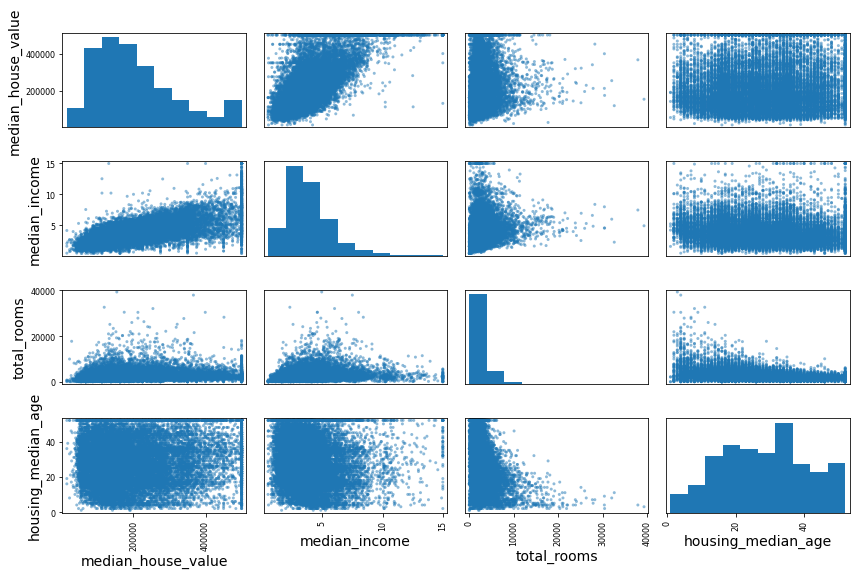

In [ ]:
from pandas.plotting import scatter_matrix

attr = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attr], figsize=(12, 8))
save_fig('corr_plot')

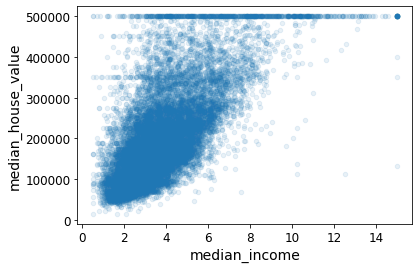

In [ ]:

house.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [ ]:
#Separate labels

housing_x = train_stf.drop('median_house_value', axis=1)
housing_y = train_stf['median_house_value'].copy()



In [ ]:
#Check for NaNs
housing_x.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


In [ ]:
#impute NaNs/drop rows/cols

median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [ ]:
cat_cols = ['ocean_proximity']

housing_num = housing_x.drop(cat_cols, axis=1)
housing_cat = housing_x[cat_cols].copy()

X = imputer.fit_transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)


#Check for NaNs

housing_tr[housing_tr.isna().any(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


In [ ]:
#OneHotEncoding

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
housing_cat = ohe.fit_transform(housing_cat)
housing_cat[:10]



<10x5 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [ ]:
#Custom Transformer for creating new features

from sklearn.base import BaseEstimator, TransformerMixin

col_names = ["total_rooms", "total_bedrooms", "population", "households"]
rooms_ix, bedrooms_ix, population_ix, households_ix = [housing.columns.get_loc(c)
                                                        for c in col_names]

# rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributes(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room=True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household,
                   bedrooms_per_room,
                   population_per_household] #Concat on 2nd axis to create a np array

    else:
      return np.c_[X, rooms_per_household,
                   population_per_household]


attr_adder = CombinedAttributes(add_bedrooms_per_room=False)
housing_extra_attr = attr_adder.transform(housing_x.values) #pass the df as array

In [ ]:
housing_extra_attr = pd.DataFrame(housing_extra_attr,
                                  columns=list(housing_x.columns)+['rooms_per_household',
                                                                 'population_per_household'],
                                  index=housing_x.index)

housing_extra_attr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


#Pipeline for attributes

In [ ]:
#Numerical Attributes

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('attr_adder', CombinedAttributes()),
                         ('std_scaler', StandardScaler()),
                        ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
         0.15531753, -0.08649871],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.83628902, -0.03353391],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
         0.4222004 , -0.09240499],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.52177644, -0.03055414],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
        -0.30340741,  0.06150916],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
         0.10180567, -0.09586294]])

In [ ]:
#Full attr pipeline
from sklearn.compose import ColumnTransformer

num_attr = list(housing_num)
cat_attr = ['ocean_proximity']

full_pipeline = ColumnTransformer([
                                    ('num', num_pipeline, num_attr),
                                    ('cat', ohe, cat_attr),
                                  ])

housing_prep = full_pipeline.fit_transform(housing_x)

#Finally train the model

In [ ]:
housing_prep.shape

(16512, 16)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prep, housing_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#Prediction

sample = housing_x.iloc[:5]
sample_labels = housing_y.iloc[:5]
sample_prep = full_pipeline.transform(sample)

pred = lin_reg.predict(sample_prep)

from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(sample_labels, pred)
lin_mae

38102.890423304765

In [ ]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(sample_labels, pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

46578.63831786737

In [ ]:
#Pred on all training data

pred = lin_reg.predict(housing_prep)
lin_mse = mean_squared_error(housing_y, pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [ ]:
#Decision Tree

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prep, housing_y)

pred = tree_reg.predict(housing_prep)
tree_mse = mean_squared_error(housing_y, pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

#Tune the model

In [ ]:
#Cross Validation

from sklearn.model_selection import cross_val_score

#10fold CV; Scoring func is an objective func (has to be maximized)
scores = cross_val_score(tree_reg, housing_prep, housing_y,
                         scoring='neg_mean_squared_error', cv=10)

tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
  print('Scores:: ', scores)
  print('Mean:: ', scores.mean())
  print('Standard deviation:: ', scores.std())

display_scores(tree_rmse_scores)

Scores::  [68927.85095887 67060.10845357 71765.78881844 69052.7789228
 71703.91284517 75076.99299686 71001.45463171 69948.09189294
 76036.38283506 71377.17700029]
Mean::  71195.05393557178
Standard deviation::  2598.951358316411


In [ ]:
#For LR
lin_scores = cross_val_score(lin_reg, housing_prep, housing_y,
                             scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores::  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean::  69052.46136345083
Standard deviation::  2731.6740017983457


In [ ]:
#Try Random Forest

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(housing_prep, housing_y)

pred = rf.predict(housing_prep)
rf_mse = mean_squared_error(housing_y, pred)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

18601.168364848658

In [ ]:
rf_scores = cross_val_score(rf, housing_prep, housing_y,
                            scoring='neg_mean_squared_error', cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
display_scores(rf_rmse_scores)

Scores::  [49498.80813186 47576.21264638 50183.68218317 52332.54227951
 49447.87116686 53537.1899883  48737.33565666 47678.59096572
 53293.41288699 50070.48711667]
Mean::  50235.61330221212
Standard deviation::  2041.9758093699695


#Hypertune parameters

In [ ]:
#SVR

from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(housing_prep, housing_y)

pred = svm_reg.predict(housing_prep)
svm_mse = mean_squared_error(housing_y, pred)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [ ]:
#Grid Search

from sklearn.model_selection import GridSearchCV

param_grid = [
              {'n_estimators': [100, 120, 140], 'max_features': [8, 12]},
              {'bootstrap': [False], 'n_estimators': [125, 150], 'max_features': [8, 12]}
]

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prep, housing_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [ ]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8, 'n_estimators': 150}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
#Score of each model tested during grid search

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(np.sqrt(-mean_score), params)


49398.004250800244 {'max_features': 8, 'n_estimators': 100}
49327.84016360511 {'max_features': 8, 'n_estimators': 120}
49317.52029128947 {'max_features': 8, 'n_estimators': 140}
49756.93259251693 {'max_features': 12, 'n_estimators': 100}
49730.103334515654 {'max_features': 12, 'n_estimators': 120}
49691.44513211807 {'max_features': 12, 'n_estimators': 140}
48775.44659580106 {'bootstrap': False, 'max_features': 8, 'n_estimators': 125}
48704.52551180574 {'bootstrap': False, 'max_features': 8, 'n_estimators': 150}
50423.31439092954 {'bootstrap': False, 'max_features': 12, 'n_estimators': 125}
50330.49199474477 {'bootstrap': False, 'max_features': 12, 'n_estimators': 150}


In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.322977,0.084660,0.115634,0.002930,8,100,NaN,"{'max_features': 8, 'n_estimators': 100}",-2.288347e+09,-2.499408e+09,-2.573254e+09,-2.296908e+09,-2.542896e+09,-2.440163e+09,1.227578e+08,5,-3.465738e+08,-3.398137e+08,-3.396260e+08,-3.492919e+08,-3.427907e+08,-3.436192e+08,3.795361e+06
1,8.717897,0.029656,0.137955,0.002447,8,120,NaN,"{'max_features': 8, 'n_estimators': 120}",-2.283553e+09,-2.491197e+09,-2.566937e+09,-2.280514e+09,-2.543978e+09,-2.433236e+09,1.258793e+08,4,-3.436333e+08,-3.351060e+08,-3.386790e+08,-3.481269e+08,-3.414275e+08,-3.413945e+08,4.410368e+06
2,10.413666,0.265412,0.161920,0.002831,8,140,NaN,"{'max_features': 8, 'n_estimators': 140}",-2.286535e+09,-2.489147e+09,-2.564013e+09,-2.272128e+09,-2.549266e+09,-2.432218e+09,1.274077e+08,3,-3.416936e+08,-3.342177e+08,-3.364367e+08,-3.472598e+08,-3.408579e+08,-3.400931e+08,4.525418e+06
3,10.513256,0.066714,0.118083,0.004706,12,100,NaN,"{'max_features': 12, 'n_estimators': 100}",-2.322722e+09,-2.521900e+09,-2.638452e+09,-2.289697e+09,-2.605991e+09,-2.475752e+09,1.439427e+08,8,-3.511239e+08,-3.488444e+08,-3.411990e+08,-3.543402e+08,-3.441393e+08,-3.479294e+08,4.728704e+06
4,12.554680,0.049653,0.137446,0.001566,12,120,NaN,"{'max_features': 12, 'n_estimators': 120}",-2.328990e+09,-2.519921e+09,-2.626844e+09,-2.286870e+09,-2.602791e+09,-2.473083e+09,1.400703e+08,7,-3.476705e+08,-3.456321e+08,-3.409332e+08,-3.533100e+08,-3.436827e+08,-3.462457e+08,4.173797e+06
5,14.618414,0.040543,0.158048,0.001673,12,140,NaN,"{'max_features': 12, 'n_estimators': 140}",-2.323430e+09,-2.515173e+09,-2.618984e+09,-2.283871e+09,-2.604741e+09,-2.469240e+09,1.403678e+08,6,-3.452888e+08,-3.426649e+08,-3.406547e+08,-3.524640e+08,-3.440994e+08,-3.450344e+08,4.023307e+06
6,15.046336,0.232984,0.178486,0.006815,8,125,False,"{'bootstrap': False, 'max_features': 8, 'n_est...",-2.292041e+09,-2.405258e+09,-2.486829e+09,-2.223595e+09,-2.487499e+09,-2.379044e+09,1.056419e+08,2,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
7,17.931002,0.107199,0.212398,0.004653,8,150,False,"{'bootstrap': False, 'max_features': 8, 'n_est...",-2.288777e+09,-2.391876e+09,-2.471492e+09,-2.226780e+09,-2.481729e+09,-2.372131e+09,1.003484e+08,1,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
8,21.809784,0.350640,0.178383,0.004123,12,125,False,"{'bootstrap': False, 'max_features': 12, 'n_es...",-2.435481e+09,-2.539701e+09,-2.644456e+09,-2.408790e+09,-2.684125e+09,-2.542511e+09,1.093544e+08,10,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
9,25.955641,0.103056,0.209248,0.002607,12,150,False,"{'bootstrap': False, 'max_features': 12, 'n_es...",-2.434543e+09,-2.539316e+09,-2.634522e+09,-2.385682e+09,-2.671729e+09,-2.533158e+09,1.104431e+08,9,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00


#Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=4, high=12)
}

rf = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(rf, params_distribs, n_iter=5, cv=5,
                                scoring='neg_mean_squared_error', random_state=42,
                                return_train_score=True)
rnd_search.fit(housing_prep, housing_y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(np.sqrt(-mean_score), params)

49503.44346032044 {'max_features': 10, 'n_estimators': 180}
50884.624061060276 {'max_features': 8, 'n_estimators': 15}
49232.73017259111 {'max_features': 6, 'n_estimators': 72}
50342.70748227801 {'max_features': 8, 'n_estimators': 21}
49606.857669019875 {'max_features': 10, 'n_estimators': 122}


In [ ]:
#Feature importances of the best model

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.36370179e-02, 6.63777878e-02, 4.14424246e-02, 1.46508611e-02,
       1.41769737e-02, 1.44231559e-02, 1.37871923e-02, 3.65591187e-01,
       4.93438494e-02, 6.38749696e-02, 1.10964282e-01, 6.26146244e-03,
       1.60046609e-01, 7.44553185e-05, 2.34016157e-03, 3.00761006e-03])

In [ ]:
extra_attr = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']

cat_encoder = full_pipeline.named_transformers_['cat']
cat_ohe = list(cat_encoder.categories_[0])
attr = num_attr + extra_attr + cat_ohe
sorted(zip(feature_importances, attr), reverse=True)

[(0.36559118705154225, 'median_income'),
 (0.16004660941686552, 'INLAND'),
 (0.11096428174883802, 'bedrooms_per_room'),
 (0.0736370178905294, 'longitude'),
 (0.06637778780971774, 'latitude'),
 (0.06387496963295779, 'pop_per_hhold'),
 (0.04934384943728898, 'rooms_per_hhold'),
 (0.0414424245512744, 'housing_median_age'),
 (0.014650861099415224, 'total_rooms'),
 (0.01442315592219538, 'population'),
 (0.014176973714386873, 'total_bedrooms'),
 (0.013787192332259165, 'households'),
 (0.006261462444379316, '<1H OCEAN'),
 (0.003007610059324222, 'NEAR OCEAN'),
 (0.0023401615704780913, 'NEAR BAY'),
 (7.445531854753505e-05, 'ISLAND')]

#Predict on Test data

In [ ]:
final_model = grid_search.best_estimator_

test_x = test_stf.drop('median_house_value', axis=1)
test_y = test_stf['median_house_value'].copy()

test_x_prep = full_pipeline.transform(test_x)
final_pred = final_model.predict(test_x_prep)

final_mse = mean_squared_error(test_y, final_pred)
final_rmse = np.sqrt(final_mse)
final_rmse

46501.016002782024

In [ ]:
#Get the CI: t scores and z scores of the generalization error

In [ ]:
from scipy import stats

confidence=0.95
squared_errors = (final_pred - test_y) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) -1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([44507.37383882, 48412.62906054])

In [ ]:
#Full pipeline for prep and pred

full_pipeline_pred = Pipeline([
                               ('prep', full_pipeline),
                               ('linear', LinearRegression())
                              ])

full_pipeline_pred.fit(housing_x, housing_y)
full_pipeline_pred.predict(housing_x[:5])

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [ ]:
#Persist the model

my_model = full_pipeline_pred

import joblib
joblib.dump(my_model, 'my_model.pkl')

my_model_loaded = joblib.load('my_model.pkl')